In [76]:
import numpy as np
import tensorly as tl
import tensorly.decomposition
#tl.decomposition.parfac()
#import tensorly.decomposition
from tensorly.decomposition import parafac,non_negative_parafac
import matplotlib.pyplot as plt
from copy import deepcopy
#from random import choice
#import math

In [77]:
'''
This is a test code, used to generate simulated data, for CP/ACMTF, and Run CP model. 
'''

class data_generator_XY():
    '''
    Used to generate A,B,C,D, and form into ACMTF data X = [A,B,C], Y = [A,D]. 
    '''
    def __init__(self, sizeA, sizeB, sizeC, sizeD, R, lambdaX, lambdaY):
        '''
        All the parameters used in generating the X and Y

        sizeA/B/C/D : the size of each ground truth matrix
        R: number of true components
        '''
        self.sizeA = sizeA
        self.sizeB = sizeB
        self.sizeC = sizeC
        self.sizeD = sizeD
        self.R = R
        self.lambdaX = lambdaX
        self.lambdaY = lambdaY

    def _generate_A_(self):
        '''Generate A'''
        self.A = np.zeros((self.sizeA,self.R))
        for R_ind in range(self.R):
            for A_ind in range(self.sizeA):
                initial_val = np.random.randn()
                self.A[A_ind,R_ind] = initial_val
        
        '''normalize'''
        for R_ind in range(self.R):
            self.A[:,R_ind] /= np.linalg.norm(self.A[:,R_ind])
        
        '''
        would better if...
        self.A = np.random.randn(self.sizeA,self.R) 
        '''

    def _generate_B_(self):
        self.B = np.random.randn(self.sizeB,self.R) 
        '''normalize'''
        for R_ind in range(self.R):
            self.B[:,R_ind] /= np.linalg.norm(self.B[:,R_ind])

    def _generate_C_(self):
        '''
        C has been stored in two versions
        Version 1: size = sizeC,R
        Version 2: size = sizeC, sizeC, R : As diagonal matrixs
        '''
        self.C = np.random.randn(self.sizeC,self.R)
        '''normalize'''
        for R_ind in range(self.R):
            self.C[:,R_ind] /= np.linalg.norm(self.C[:,R_ind])


        self.C_diag = [deepcopy(np.eye(self.R))]
        for C_ind in range(self.sizeC):
            self.C_diag.append(deepcopy(self.C_diag[-1]))
            for R_ind in range(self.R):
                self.C_diag[C_ind][R_ind,R_ind] = self.C[C_ind,R_ind]

    





    def _generate_D_(self):
        self.D = np.random.randn(self.sizeD,self.R) 
        '''normalize'''
        for R_ind in range(self.R):
            self.D[:,R_ind] /= np.linalg.norm(self.D[:,R_ind])



    def _generate_data(self):
        # Generate tensor and matrix data

        self._generate_A_()
        self._generate_B_()
        self._generate_C_()
        self._generate_D_()

        X = tl.zeros((self.sizeA,self.sizeB,self.sizeC))
        
        # method 1 to calculate X
        for C_ind in range(self.sizeC):
            X[...,C_ind] = self.A @ self.C_diag[C_ind] @ np.diagflat(self.lambdaX) @ self.B.T

        # method 2 to calculate X
        #X = tl.cp_to_tensor([self.lambdaX;self.A,self.B,self.C])

        X_normalize = deepcopy(X)
        X_normalize /= np.linalg.norm(X_normalize)

        Y = tl.zeros((self.sizeA,self.sizeD))
        Y = self.A @ np.diagflat(self.lambdaY) @ self.D.T
        Y_normalize = deepcopy(Y)
        Y_normalize /= np.linalg.norm(Y_normalize)
        
        self.X = X
        self.Y = Y
        self.X_normalize = X_normalize
        self.Y_normalize = Y_normalize

    

    
    def _test_X( self , test_pos_X = 0 , test_pos_Y = 0 , test_pos_Z = 0 ):
        '''
        To test whether the calculation of X is correct. 
        Default posotion set as [0,0,0]
        Extra input position is [X Y Z]
        '''

        try:
            self.X
        except:
            raise ValueError('Please generate data first!')

        test_value = 0
        for R_ind in range(self.R):
            test_value += self.lambdaX[R_ind] * self.A[test_pos_X,R_ind] * self.B[test_pos_Y,R_ind] * self.C[test_pos_Z,R_ind]

        print(f'Auto result for X at position {test_pos_X} {test_pos_Y} {test_pos_Z} is {self.X[test_pos_X,test_pos_Y,test_pos_Z]}')
        print(f'Manual result for X at position {test_pos_X} {test_pos_Y} {test_pos_Z} is {test_value}')    

    def _test_Y( self , test_pos_X = 0 , test_pos_Y = 0 ):
        '''
        To test whether the calculation of Y is correct. 
        Default posotion set as [0,0]
        Extra input position is [X Y]
        '''

        try:
            self.Y
        except:
            raise ValueError('Please generate data first!')

        test_value = 0
        for R_ind in range(self.R):
            test_value += self.lambdaY[R_ind] * self.A[test_pos_X,R_ind] * self.D[test_pos_Y,R_ind]

        print(f'Auto result for Y at position {test_pos_X} {test_pos_Y} is {self.Y[test_pos_X,test_pos_Y]}')
        print(f'Manual result for Y at position {test_pos_X} {test_pos_Y} is {test_value}')  
        

    def _parafac_all( self , multi_initialization = 20 , normalized_X = 0):
        '''
        Apply CP model (PARAFAC) on the X. 
        Step 1: normalize the input X
        Step 2: run multiple CP model, default R = 3.
        Step 3: ?
        '''
        
        try:
            self.X
        except:
            raise ValueError('Please generate data first!')
        

        # normalize X
        CP_input = self.X
        if normalized_X == 1:
            CP_input = self.X_normalize

        CP_input /= np.linalg.norm(CP_input)

        # center and scaling on X needed. 

        # run CP 
        #for i in range(multi_initialization):

        # run 1 time first
        self.all_result = []
        for i in [1,2,3,4,5,6]:
                    # run CP 
            max_model_fit = 0
            for run_times in range(10):
                cp_result = parafac( self.X , rank=i, init='random' )
                cur_model_fit = 1 - tl.norm(self.X - tl.cp_to_tensor(cp_result))/tl.norm(self.X)
                if cur_model_fit>=max_model_fit:
                    best_result = cp_result

            cp_result = best_result
            # need to normalize cp_result
            for j in range(i):
                cp_result[0][j] *= np.linalg.norm(cp_result[1][0][:,j]) * np.linalg.norm(cp_result[1][1][:,j]) * np.linalg.norm(cp_result[1][2][:,j])
                cp_result[1][0][:,j] /= np.linalg.norm(cp_result[1][0][:,j])
                cp_result[1][1][:,j] /= np.linalg.norm(cp_result[1][1][:,j])
                cp_result[1][2][:,j] /= np.linalg.norm(cp_result[1][2][:,j])

            # save the CP result
            self.all_result.append(cp_result)

        #
        #try:
        #    self.cp_result[0]
        #except:
        #    for i in range(10):
        #        self.cp_result[i] = deepcopy(cp_result)
        
        #self.cp_result = cp_result
        
    def _parafac_givenR( self , givenR = 3 , multi_initialization = 20 ):
        '''
        Apply CP model (PARAFAC) on the X. 
        Step 1: normalize the input X
        Step 2: run multiple CP model, default R = 3.
        Step 3: ?
        '''
        
        try:
            self.X
        except:
            raise ValueError('Please generate data first!')
        

        

        # normalize X
        CP_input = self.X
        CP_input /= np.linalg.norm(CP_input)

        # center and scaling on X needed. 
        
        # run CP 
        max_model_fit = 0
        for run_times in range(10):
            cp_result = parafac( self.X , rank=givenR, init='random' )
            cur_model_fit = 1 - tl.norm(self.X - tl.cp_to_tensor(cp_result))/tl.norm(self.X)
            if cur_model_fit>=max_model_fit:
                best_result = cp_result

        cp_result = best_result
# need to normalize cp_result
        for j in range(givenR):
            cp_result[0][j] *= np.linalg.norm(cp_result[1][0][:,j]) * np.linalg.norm(cp_result[1][1][:,j]) * np.linalg.norm(cp_result[1][2][:,j])
            cp_result[1][0][:,j] /= np.linalg.norm(cp_result[1][0][:,j])
            cp_result[1][1][:,j] /= np.linalg.norm(cp_result[1][1][:,j])
            cp_result[1][2][:,j] /= np.linalg.norm(cp_result[1][2][:,j])


        self.cp_result = cp_result

        #
        #try:
        #    self.cp_result[0]
        #except:
        #    for i in range(10):
        #        self.cp_result[i] = deepcopy(cp_result)
        
        #self.cp_result = cp_result

    def _show_ground_truth_A_heat(self):
        '''Heat map'''
        fig, axes = plt.subplots(1,1,figsize=(5,5))

        fig.suptitle(t='Factor A',fontsize=20,x=0.725)

        im = axes.imshow(self.A)

        axes.set_xticks([])
        axes.set_yticks([])

        fig.colorbar(im,ax=axes,pad=0.02)
        print('Unfinished code')

    def _reorder_cur_fac( self, cur_fac ):
        # reorder the cur_fac to the ground truth
        cur_fac_reordered = deepcopy(cur_fac)
        for ig in range(self.R):
            for ir in range(self.R):
                # check the similairty between comp ig and comp ir
                cur_igir_similar = sum(self.A[:,ig] * cur_fac[1][0][:,ir]) * sum(self.B[:,ig] * cur_fac[1][1][:,ir]) * sum(self.C[:,ig] * cur_fac[1][2][:,ir])
                if np.abs(cur_igir_similar) > 0.95:
                    cur_fac_reordered[0][ig] = cur_fac[0][ir]
                    flip = 1
                    if sum(self.A[:,ig] * cur_fac[1][0][:,ir])>0:
                        cur_fac_reordered[1][0][:,ig] = cur_fac[1][0][:,ir]
                    else:
                        cur_fac_reordered[1][0][:,ig] = cur_fac[1][0][:,ir] * (-1)
                        flip = flip*(-1)

                    if sum(self.B[:,ig] * cur_fac[1][1][:,ir])>0:
                        cur_fac_reordered[1][1][:,ig] = cur_fac[1][1][:,ir]
                    else:
                        cur_fac_reordered[1][1][:,ig] = cur_fac[1][1][:,ir] * (-1)
                        flip = flip*(-1)
                    
                    cur_fac_reordered[1][2][:,ig] = cur_fac[1][2][:,ir]*flip
                    break

        self.cur_fac_reordered = cur_fac_reordered

    def _show_ground_all_plotxy( self , cur_fac ):
        '''Plot(1:sizeA,value_A)'''
        fig, axes = plt.subplots(3,self.R,constrained_layout=True)

        # need to permute the cur_fac to the ground truth. 
        # for each component ig in the ground truth,
        # find one similar in the result as ir, 
        # if ir<=ig, skip and try to find next, 
        # if ir>ig, otherwise switch ig and ir.  
        # finish


        # plot the reordered fac

        # show each component at each mode
        for i in range(self.R):
            axes[0][i].plot(self.A[:,i], color='tab:blue' , label = f'a{i} truth')
            axes[0][i].plot(cur_fac[1][0][:,i], color='tab:red' , label = f'a{i} result', linewidth=0.5, marker = '+')
            axes[0][i].legend(prop={'size': 8})

        for i in range(self.R):
            axes[1][i].plot(self.B[:,i], color='tab:blue' , label = f'b{i} truth')
            axes[1][i].plot(cur_fac[1][1][:,i], color='tab:red' , label = f'b{i} result', linewidth=0.5, marker = '+')
            axes[1][i].legend(prop={'size': 8})
        
        for i in range(self.R):
            axes[2][i].plot(self.C[:,i], color='tab:blue' , label = f'c{i} truth')
            axes[2][i].plot(cur_fac[1][2][:,i], color='tab:red' , label = f'c{i} result', linewidth=0.5, marker = '+')
            axes[2][i].legend(prop={'size': 8})
        
    def _show_ground_truth_plotxy( self ):
        '''Plot(1:sizeA,value_A_true)'''
        fig, axes = plt.subplots(3,self.R,constrained_layout=True)
        for i in range(self.R):
            axes[0][i].plot(self.A[:,i], color='tab:blue' , label = f'a{i} truth')
            axes[0][i].legend(prop={'size': 8})

        for i in range(self.R):
            axes[1][i].plot(self.B[:,i], color='tab:blue' , label = f'b{i} truth')
            axes[1][i].legend(prop={'size': 8})
        
        for i in range(self.R):
            axes[2][i].plot(self.C[:,i], color='tab:blue' , label = f'c{i} truth')
            axes[2][i].legend(prop={'size': 8})


    def _show_parafac_result(self, givenR = 3):
        '''
        Used to show the result of a CP model
        - ~~check if R-comp model exists~~ 
        - plot groundtruth
        - plot result
        '''
        data_exists = 2
        try:
            self.cp_result
            if len(self.cp_result.weight) != givenR:
                data_exists -= 1
        except:
            data_exists -= 1

        try:
            self.all_result
        except:
            data_exists -= 1

        try:
            self.all_result[givenR]
        except:
            data_exists -= 1

        if data_exists < 1:
            raise ValueError('Please run CP model first!')

        try:
            current_data = self.all_result[givenR]
        except:
            current_data = self.cp_result
            
        '''Plot groundtruth'''
        

        print('Unfinished code')


        



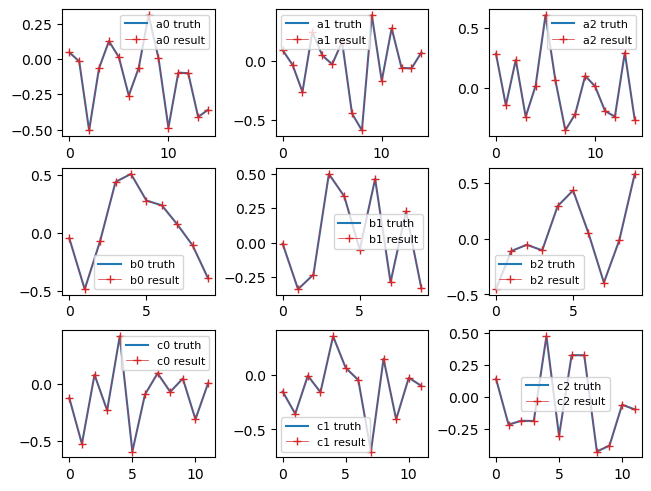

In [78]:
### Test generating data
generator_XY_1 = data_generator_XY(
sizeA = 15,
sizeB = 10,
sizeC = 12,
sizeD = 10,
R = 3,
lambdaX = np.array([1,1,1]),
lambdaY = np.array([1,1,1])
)
generator_XY_1._generate_data()
#generator_XY_1._test_X(0,0,1)
#generator_XY_1._test_X(0,0,0)
#generator_XY_1._test_X()
#generator_XY_1._test_Y()
#generator_XY_1._test_Y(0,0)

generator_XY_1._parafac_all()
generator_XY_1._parafac_givenR(givenR = 3)
#generator_XY_1._show_parafac_result()

#print(generator_XY_1.cp_result)

#generator_XY_1._parafac(givenR = 3)
#cp_result = parafac( generator_XY_1.X , rank=3 , init='random' )
#cp_result2 = parafac( generator_XY_1.X , rank=3 , init='random' )
# next is to test whether X and Y are correct. By showing A B C D and X Y. should be right. 

#X = tl.cp_to_tensor(generator_XY_1.lambdaX,[generator_XY_1.A,generator_XY_1.B, generator_XY_1.C])
#print(f'{cp_result}')
#print(f'{cp_result2}')

generator_XY_1._reorder_cur_fac(generator_XY_1.cp_result)
generator_XY_1._show_ground_all_plotxy(generator_XY_1.cur_fac_reordered)